# Installation et importation des bibliothèques

In [3]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.models import Sequential



# Montage de Google Drive et extraction des fichiers

In [4]:
from google.colab import drive
import zipfile



In [5]:
# Définir le chemin vers ton fichier ZIP
zip_path = "/content/malaria_hematie_dataset.zip"
extract_path = "/content/dataset/"


In [6]:
# Décompression
if not os.path.exists(os.path.join(extract_path)):# Vérifier si le dataset est déjà extrait pour éviter les doublons à chaque éxécution
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Fichier extrait dans : {extract_path}")
else:
    print("Le dataset est déjà extrait, passage à l'étape suivante.")

Fichier extrait dans : /content/dataset/


#Chargement et prétraitement des images

In [7]:
import os
import numpy as np
from PIL import Image  # Importation de PIL pour le traitement d’images

img_size = 64  # Redimensionnement des images
classes = ["parasitized", "uninfected"]  # Classes binaires

def load_images(directory):
    images, labels = [], []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")  # Conversion en RGB pour uniformiser
                    img = img.resize((img_size, img_size))  # Redimensionnement
                    img = np.array(img) / 255.0  # Normalisation [0,1]
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Erreur avec l'image {img_path}: {e}")

    return np.array(images), np.array(labels)
    print(labels)

In [8]:
#  Chargement des données
new_path = "/content/dataset/malaria_hematie_dataset"
x, y = load_images(new_path)
print(y)

[0 0 0 ... 1 1 1]


In [9]:
# Encodage des labels pour la classification binaire
y = to_categorical(y, num_classes=len(classes))
print(f"Total d'images chargées: {x.shape[0]}")

Total d'images chargées: 27558


In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.15 + 0.15  # 30% au total pour validation + test
val_size = 0.15 / (0.15 + 0.15)  # 50% de test_size pour validation (~15% total)


# Premiere division: 70% training, 30% temporary (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=test_size, random_state=42, stratify=y
)


# Deuxième division: 15% validation, 15% test
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
)

# Vérification des tailles
print(f"Taille du dataset - Train: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

Taille du dataset - Train: (19290, 64, 64, 3), Validation: (4134, 64, 64, 3), Test: (4134, 64, 64, 3)


# **Chargement des bibliothèques et préparation des données**

# Générateur d'image

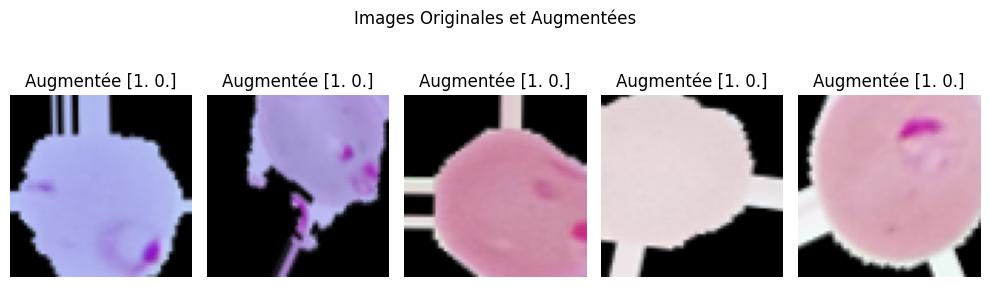

In [11]:
# Définir l'ImageDataGenerator pour la data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Sélectionner un sous-ensemble d'images pour visualiser les augmentations
sample_images = x[:5]  # Utiliser les 5 premières images de l'ensemble
sample_labels = y[:5]

# Créer le générateur d'images augmentées
augmented_images = datagen.flow(sample_images, batch_size=1)

# Affichage des images augmentées
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    augmented_img = next(augmented_images)[0].astype(np.float32)  # Obtenir l'image augmentée
    plt.imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Augmentée {sample_labels[i]}")
    plt.axis("off")

plt.suptitle("Images Originales et Augmentées")
plt.tight_layout()
plt.show()

In [12]:
# Création des générateurs
train_datagen = datagen
val_datagen = datagen
train_generator = train_datagen.flow(x_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(x_test, y_test, batch_size=32, shuffle=False)


# **Modélisation et entraînement**

**CNN Simple avec Sequential**

from_scratch

In [13]:
# Définition du modèle
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compilation du modèle with categorical_crossentropy because of one-hot encoding
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Entraînement du modèle
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,458 (2.61 MB)

 Trainable params: 683,458 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 - 42s - 70ms/step - accuracy: 0.7834 - loss: 0.4420 - val_accuracy: 0.8974 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 2/50
603/603 - 28s - 47ms/step - accuracy: 0.9059 - loss: 0.2682 - val_accuracy: 0.9231 - val_loss: 0.2210 - learning_rate: 0.0010
Epoch 3/50
603/603 - 29s - 49ms/step - accuracy: 0.9137 - loss: 0.2470 - val_accuracy: 0.9289 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 4/50
603/603 - 29s - 48ms/step - accuracy: 0.9171 - loss: 0.2384 - val_accuracy: 0.9330 - val_loss: 0.2006 - learning_rate: 0.0010
Epoch 5/50
603/603 - 29s - 47ms/step - accuracy: 0.9224 - loss: 0.2275 - val_accuracy: 0.9398 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 6/50
603/603 - 30s - 49ms/step - accuracy: 0.9236 - loss: 0.2208 - val_accuracy: 0.9311 - val_loss: 0.1892 - learning_rate: 0.0010
Epoch 7/50
603/603 - 29s - 48ms/step - accuracy: 0.9241 - loss: 0.2202 - val_accuracy: 0.9381 - val_loss: 0.1879 - learning_rate: 0.0010
Epoch 8/50
603/603 - 29s - 48ms/step - accuracy: 0.9

In [14]:

# Sauvegarde du modèle
# Définir le chemin du dossier où le modèle sera sauvegardé
model_save_dir = '/content/models'

# Créer le dossier s'il n'existe pas déjà
os.makedirs(model_save_dir, exist_ok=True)

# Sauvegarde du modèle dans le dossier spécifié
cnn_model.save(os.path.join(model_save_dir, "cnn_simple_model.keras"))

**Fine-Tuning du modèle VGG16**

In [15]:
import os

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False # Ceci permet de geler les couches convolutives pré-entraînées

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)  # Ici on active la sigmoïde pour la classification binaire

# Ici on vas créer le modèle final
vgg16_model = Model(inputs=base_model.input, outputs=x)

# Compilation du modèle
vgg16_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Affichage de l’architecture du modèle
vgg16_model.summary()

# Entraînement du modèle
history = vgg16_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,239,746 (58.14 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - accuracy: 0.8082 - loss: 0.4428 - val_accuracy: 0.8868 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - accuracy: 0.8672 - loss: 0.3220 - val_accuracy: 0.8996 - val_loss: 0.2624 - learning_rate: 0.0010
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8716 - loss: 0.3154 - val_accuracy: 0.8970 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.8739 - loss: 0.3090 - val_accuracy: 0.8909 - val_loss: 0.2781 - learning_rate: 0.0010
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.8772 - loss: 0.3013 - val_accuracy: 0.8858 - val_loss: 0.2805 - learning_rate: 0.0010
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.8794 - loss: 0.2934 - val_accuracy: 0.8977 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8807 - l

In [16]:
# Sauvegarde du modèle

# Définir le chemin du dossier où le modèle sera sauvegardé
model_save_dir = '/content/models'

# Créer le dossier s'il n'existe pas déjà
os.makedirs(model_save_dir, exist_ok=True)

# Sauvegarde du modèle dans le dossier spécifié
vgg16_model.save(os.path.join(model_save_dir, "vgg16_model.keras"))

**Fine-Tuning du modèle ResNet50**

In [17]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model_resnet.layers:
    layer.trainable = False # Gêle des couches convolutives pré-entraînées

x = Flatten()(base_model_resnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

# Création du modèle final
resnet50_model = Model(inputs=base_model_resnet.input, outputs=x)

# Compilation le modèle
resnet50_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Affichage de l’architecture du modèle
resnet50_model.summary()

# Entraînement du modèle
history = resnet50_model.fit(
    train_generator,  # Données d'entraînement
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,685,634 (97.98 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5502 - loss: 0.7283 - val_accuracy: 0.5854 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 65ms/step - accuracy: 0.5820 - loss: 0.6727 - val_accuracy: 0.6234 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.6062 - loss: 0.6630 - val_accuracy: 0.6229 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.6068 - loss: 0.6629 - val_accuracy: 0.6217 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.6062 - loss: 0.6590 - val_accuracy: 0.6381 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.6112 - loss: 0.6586 - val_accuracy: 0.6594 - val_loss: 0.6295 - learning_rate: 5.0000e-04
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.6307

**Chargement des modèles**

In [18]:
# Sauvegarde du modèle
# Définir le chemin du dossier où le modèle sera sauvegardé
model_save_dir = '/content/models'

# Créer le dossier s'il n'existe pas déjà
os.makedirs(model_save_dir, exist_ok=True)

# Sauvegarde du modèle dans le dossier spécifié
vgg16_model.save(os.path.join(model_save_dir, "vgg16_model.keras")) # Changed cnn_model to vgg16_model and removed extra "models/" from the path

In [19]:
# Sauvegarde du modèle
# Définir le chemin du dossier où le modèle sera sauvegardé
model_save_dir = '/content/models'

# Créer le dossier s'il n'existe pas déjà
os.makedirs(model_save_dir, exist_ok=True)

# Sauvegarde du modèle dans le dossier spécifié
resnet50_model.save(os.path.join(model_save_dir, "resnet50_model.keras")) # Changed cnn_model to resnet50_model and removed extra "models/" from the path

In [20]:
from tensorflow.keras.models import load_model

cnn_model = load_model("/content/models/cnn_simple_model.keras")
vgg16_model = load_model("/content/models/vgg16_model.keras")
resnet50_model = load_model("/content/models/resnet50_model.keras")

**Le graphique ROC et calculer l’AUC**

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step


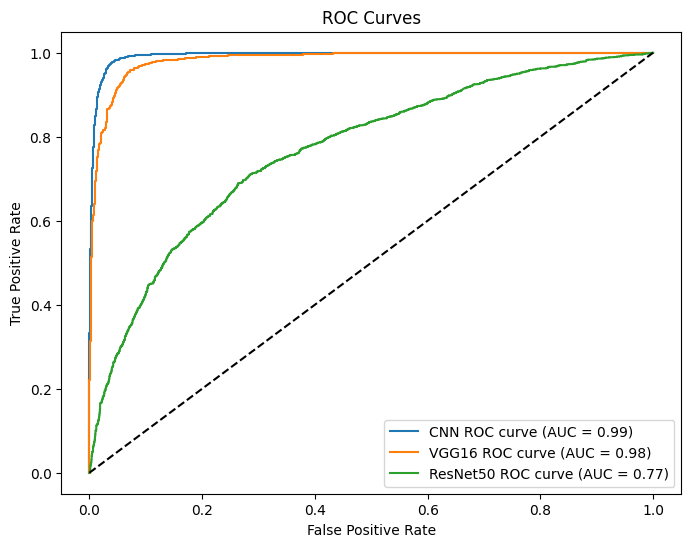

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

# Define a function to plot the ROC curve
def plot_roc_curve(model, x_test, y_test, model_name):
    y_probs = model.predict(x_test)[:, 1]  # Probabilités de la classe positive
    y_true = np.argmax(y_test, axis=1)

    # Tracer la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)

    plt.plot(fpr, tpr, label=f'{model_name} ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for all models in one figure
plt.figure(figsize=(8, 6))

plot_roc_curve(cnn_model, x_test, y_test, "CNN")
plot_roc_curve(vgg16_model, x_test, y_test, "VGG16")
plot_roc_curve(resnet50_model, x_test, y_test, "ResNet50")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

**Matrice de confusion**

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


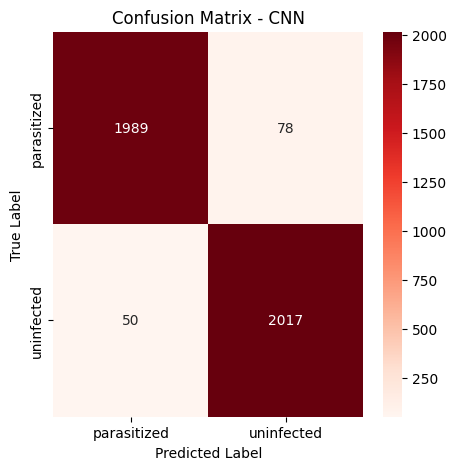

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


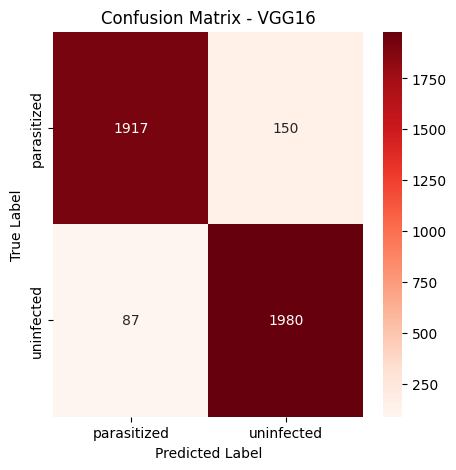

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


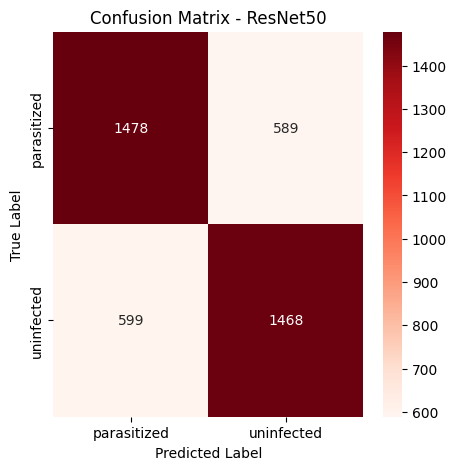

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Define a function to calculate and plot the confusion matrix
def plot_confusion_matrix(model, x_test, y_test, model_name):
    y_probs = model.predict(x_test)[:, 1]
    y_true = np.argmax(y_test, axis=1)

    # Find optimal threshold (you can adjust this part if needed)
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_probs >= optimal_threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(cnn_model, x_test, y_test, "CNN")
plot_confusion_matrix(vgg16_model, x_test, y_test, "VGG16")
plot_confusion_matrix(resnet50_model, x_test, y_test, "ResNet50")

**Métriques de performance**

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def calculate_and_print_metrics(model, x_test, y_test, model_name):
    y_probs = model.predict(x_test)[:, 1]
    y_true = np.argmax(y_test, axis=1)

    # Find optimal threshold (you can adjust this part if needed)
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_probs >= optimal_threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Metrics for {model_name}:")
    print(f"  Précision : {precision:.2f}")
    print(f"  Rappel : {recall:.2f}")
    print(f"  F1-score : {f1:.2f}")
    print(f"  Exactitude : {accuracy:.2f}")
    print("-" * 20)  # Separator


# Calculate and print metrics for each model
calculate_and_print_metrics(cnn_model, x_test, y_test, "CNN")
calculate_and_print_metrics(vgg16_model, x_test, y_test, "VGG16")
calculate_and_print_metrics(resnet50_model, x_test, y_test, "ResNet50")

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Metrics for CNN:
  Précision : 0.96
  Rappel : 0.98
  F1-score : 0.97
  Exactitude : 0.97
--------------------
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Metrics for VGG16:
  Précision : 0.93
  Rappel : 0.96
  F1-score : 0.94
  Exactitude : 0.94
--------------------
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Metrics for ResNet50:
  Précision : 0.71
  Rappel : 0.71
  F1-score : 0.71
  Exactitude : 0.71
--------------------


In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Charger les poids du modèle sauvegardé
cnn_model = load_model("/content/models/cnn_simple_model.keras")


# Définir une fonction pour prétraiter la nouvelle image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(64, 64))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Chemin d'accès à la nouvelle image que vous souhaitez classifier
new_image_path = "/content/dataset/malaria_hematie_dataset/parasitized/image_10002.png"

# Prétraiter l'image
preprocessed_image = preprocess_image(new_image_path)

# Faire une prédiction
prediction = cnn_model.predict(preprocessed_image)

# Interpréter la prédiction
predicted_class_index = np.argmax(prediction)
if predicted_class_index == 0:
    print("Prédiction: Infecté")
else:
    print("Prédiction: Non infecté")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Prédiction: Infecté
